In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as datetime
from bs4 import BeautifulSoup as bs
import requests
import sys
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

now = datetime.datetime.today()
ido = str(now.hour)+':'+str(now.minute)
now = str(now.month)+'/'+str(now.day)+'/'+str(now.year)[2:]


DATA_URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
FILE_C = "time_series_covid19_confirmed_global.csv"
FILE_D = "time_series_covid19_deaths_global.csv"
FILE_R = "time_series_covid19_recovered_global.csv"
country_table = {'United Kingdom': 'UK', 'United Arab Emirates': 'UAE', 'USA': 'US', 'Cote d\'Ivoire': 'Ivory Coast',
                 'Congo (Brazzaville)': 'Congo', 'Saint Vincent and the Grenadines': 'St. Vincent Grenadines',
                 'Korea, South': 'S. Korea', 'Taiwan*': 'Taiwan'}

f_c = pd.read_csv(DATA_URL+FILE_C)
f_d = pd.read_csv(DATA_URL+FILE_D)
f_r = pd.read_csv(DATA_URL+FILE_R)


In [71]:
def load_data(data, country):
    countries = []
    lowercase = lambda x: str(x).lower()
    data.rename(lowercase, axis="columns", inplace=True)
    data.rename(columns={'country/region':'country', 'province/state':'state'}, inplace=True)
    data.fillna(0, inplace=True)
    countries.append(list(data['country']))
    data = data[data['country'] == country]
    if not data[data.state == 0].empty:
        data = data[data.state == 0]
    data = data.groupby(['country']).sum()
    data = data.iloc[:,4:].T
    data = data[(data.T != 0).any()]
    data.rename(columns={data.columns[0]: 'Case'}, inplace=True)
    return data, countries

def str2int(s):
    if s == ' ':
        return 0
    s = s.replace(',','')
    return int(s) 

In [3]:
the_country = 'Hungary'

In [4]:
df_d,_ = load_data(f_d, the_country) # Halottak
df_r,_ = load_data(f_r, the_country) # Gyógyultak
df_c,_ = load_data(f_c, the_country) # Esetek

df = pd.DataFrame()
df['Cases'] = df_c['Case']
df['Recovered'] = df_r['Case']
df['Dead'] = df_d['Case']

dfT = df.T
dfT.tail()

,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
Cases,2.0,2.0,2.0,4.0,7.0,9.0,9.0,13.0,13.0,19.0,...,585.0,623.0,678.0,733.0,744.0,817.0,895.0,980.0,1190.0,1310.0
Recovered,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,42.0,43.0,58.0,66.0,67.0,71.0,94.0,96.0,112.0,115.0
Dead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.0,26.0,32.0,34.0,38.0,47.0,58.0,66.0,77.0,85.0


In [5]:
if the_country == 'Hungary':
    url='https://koronavirus.gov.hu/'
    page = requests.get(url)
    soup = bs(page.content, 'html.parser')
    c = soup.find_all(class_ = 'number')
    eset = int(c[0].text.replace(' ',''))
    gyogyult = int(c[1].text.replace(' ',''))
    page = 0
    hl = []

    while True:
        try:
            url = f'https://koronavirus.gov.hu/elhunytak?page={page}'
            hp = pd.read_html(url)
            hl.append(hp[0])
            page += 1
        except:
            break

    hf = pd.DataFrame(hl[0])
    for x in range(1, len(hl)):
        hf = hf.append(pd.DataFrame(hl[x]))


    hf.drop(['Sorszám', 'Alapbetegségek'], axis=1, inplace = True)
    halott = hf.shape[0]
    avg_man = round(hf[hf['Nem'] == 'Férfi'].Kor.mean(),2)
    avg_wmn = round(hf[hf['Nem'] == 'Nő'].Kor.mean(),2)

    gr = hf.groupby(['Nem']).count()                    

    ages = lambda x: int(str(x)[:-1]+'0')
    hf['Kor'] = hf['Kor'].apply(ages)
    hf = hf.groupby(hf['Kor']).count()

    gr.rename(columns = {'Kor': 'Eset/Nem'}, inplace = True)
    hf.rename(columns = {'Nem': 'Eset/Korcsoport'}, inplace = True)

    
    dfT[now] = [eset, gyogyult, halott]
else:
    if the_country in country_table:
        the_country = country_table[the_country]

    url = 'https://www.worldometers.info/coronavirus/#countries'
    page = requests.get(url)
    soup = bs(page.content, 'html.parser')
    tbl = soup.find(id='main_table_countries_today')
    tbl = tbl.findAll('tr')
    eset = -1
    for tr in tbl:
        if the_country in tr.text:
            tds = tr.findAll('td')
            eset = str2int(tds[1].text)
            halott = str2int(tds[3].text)
            gyogyult = str2int(tds[5].text)
            break
    if eset > -1:
        dfT[now] = [eset, gyogyult, halott]
    else:
        print(f'{the_country} is not on [page]({url}).')
df.tail()

,Cases,Recovered,Dead
4/7/20,817,71.0,47.0
4/8/20,895,94.0,58.0
4/9/20,980,96.0,66.0
4/10/20,1190,112.0,77.0
4/11/20,1310,115.0,85.0


In [6]:
df = dfT.T
df.fillna(0, inplace= True)
df['Active'] = df['Cases']-df['Recovered'] - df['Dead']

df = df.reset_index()
df.rename(columns = {'index': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(['Date'], drop=True, inplace=True)

df['Active'] = df['Cases']-(df['Recovered']+df['Dead'])
df['Cases+'] = df['Cases'].shift(1)
df['Dead+'] = df['Dead'].shift(1)
df['Recovered+'] = df['Recovered'].shift(1)
df.fillna(0, inplace=True)
df['Cases/day'] = abs(df['Cases'] - df['Cases+'])
df['Deads/day'] = abs(df['Dead'] - df['Dead+'])
df['Recovered/day'] = abs(df['Recovered'] - df['Recovered+'])

df.drop(['Cases+', 'Dead+', 'Recovered+'], axis=1, inplace=True)
df = df.astype(int)

m_cases = df['Cases'].iloc[-1]
m_recovered = df['Recovered'].iloc[-1]
m_dead = df['Dead'].iloc[-1]
m_active = df['Active'].iloc[-1]
df.tail()

,Cases,Recovered,Dead,Active,Cases/day,Deads/day,Recovered/day
Date,,,,,,,
2020-04-08,895,94,58,743,78,11,23
2020-04-09,980,96,66,818,85,8,2
2020-04-10,1190,112,77,1001,210,11,16
2020-04-11,1310,115,85,1110,120,8,3
2020-04-12,1410,118,99,1193,100,14,3


Image saved as: hungary.png


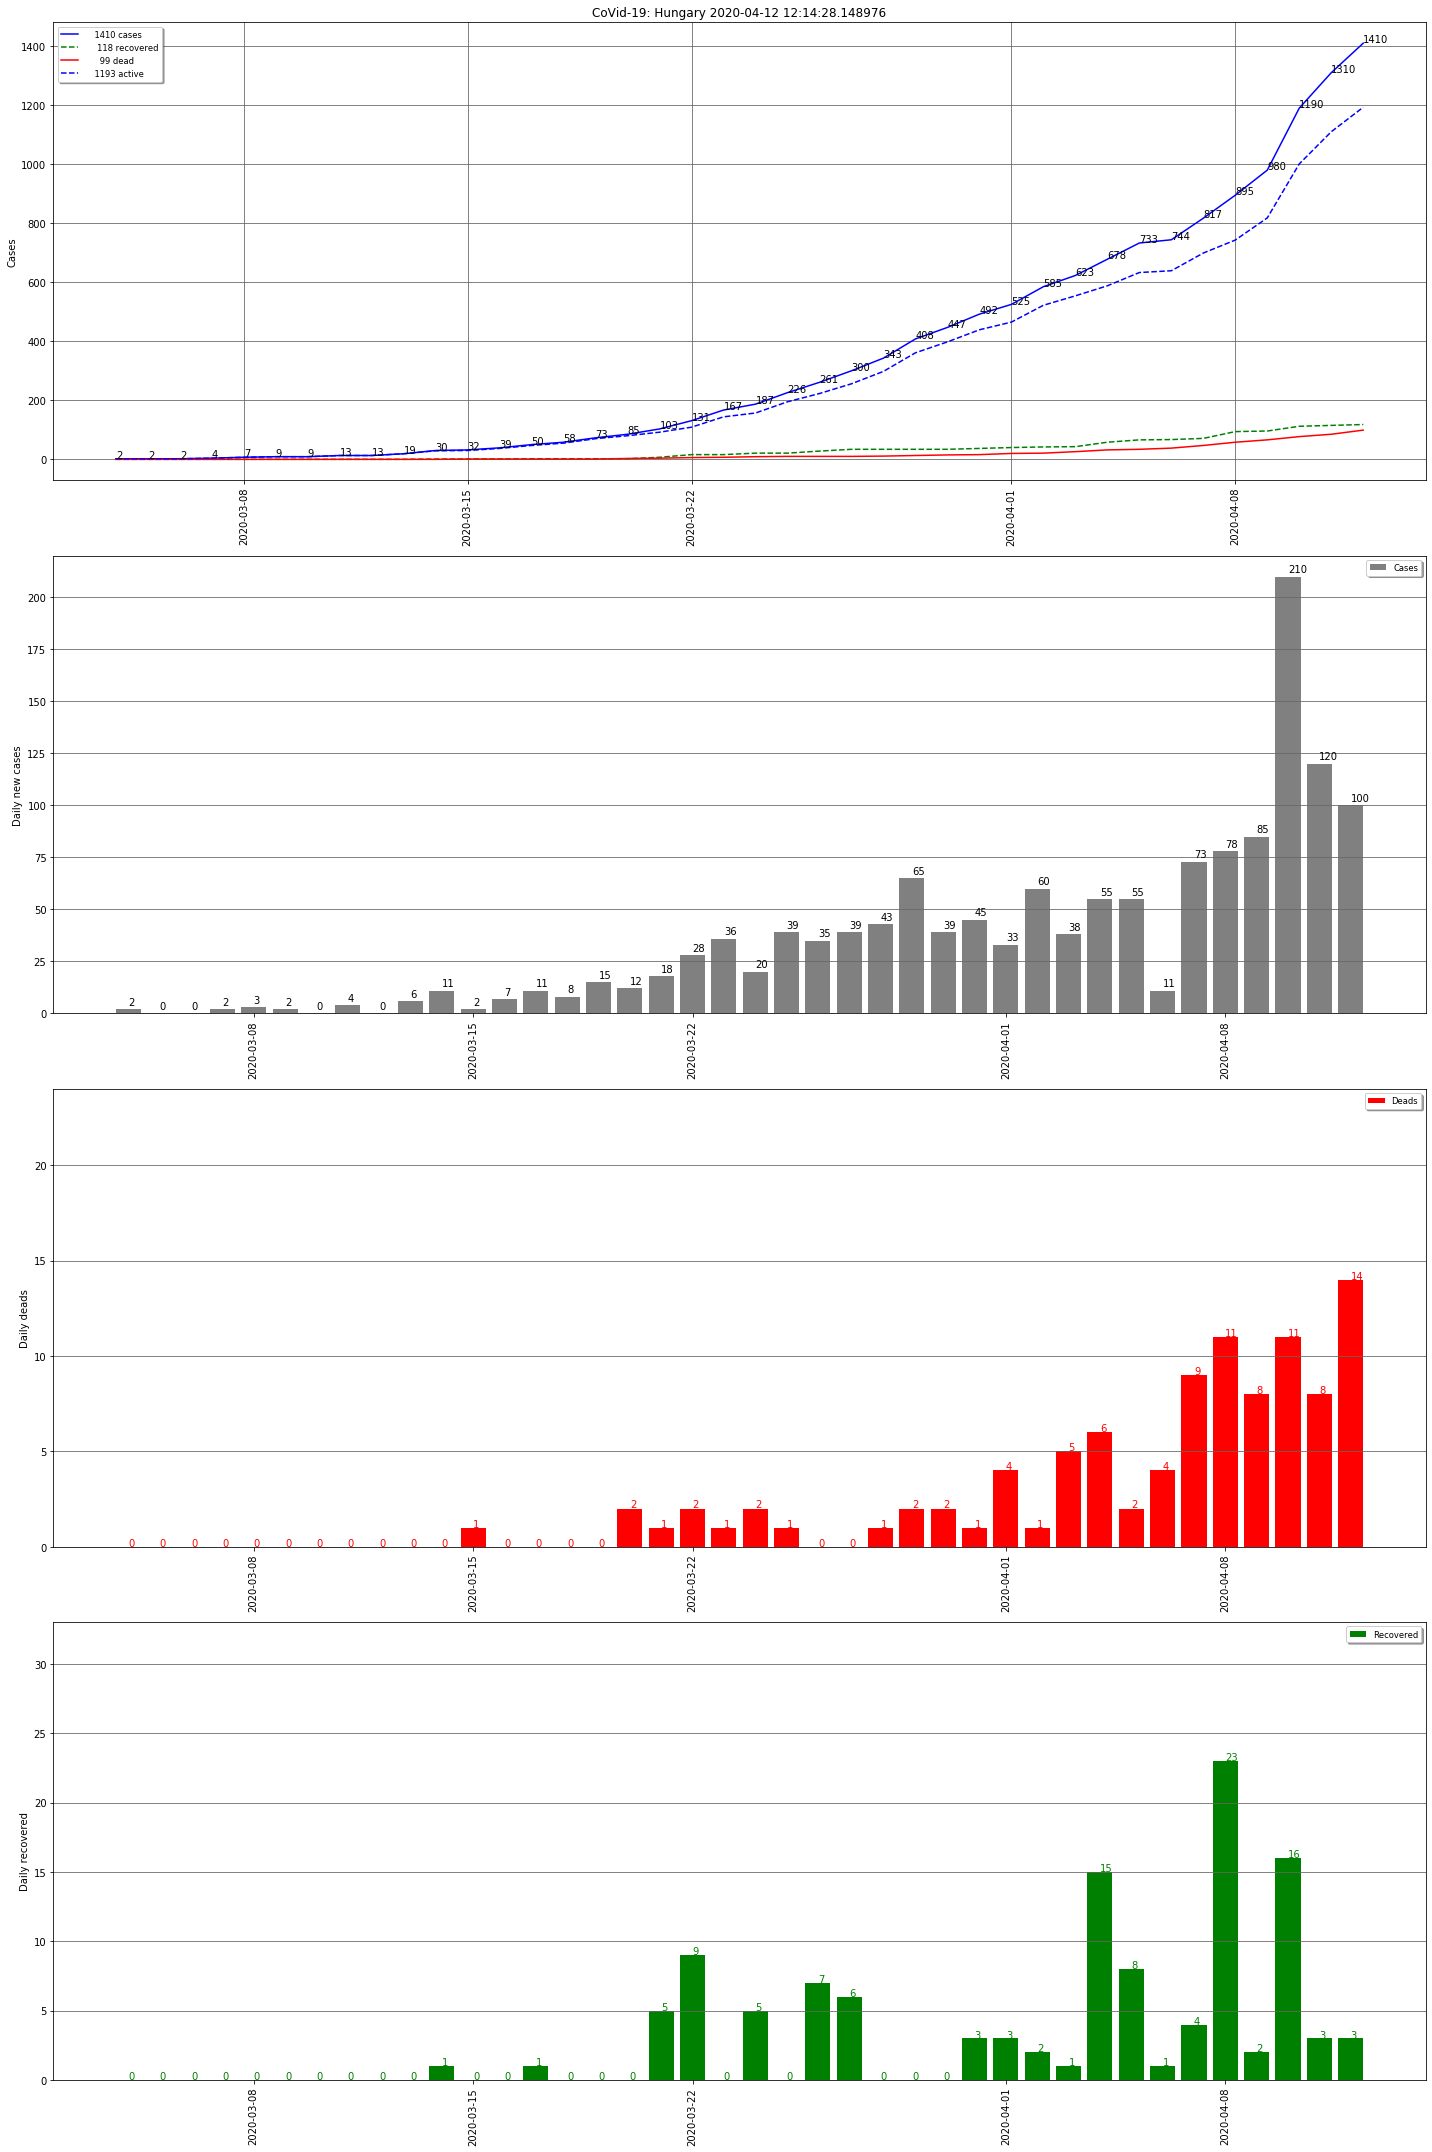

In [7]:
plt.figure(figsize=(20,30), tight_layout=True)

ax = plt.subplot(411, frameon=True)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(df.index, df['Cases'], 'b-',     label=f"{df['Cases'].max():8} cases")
plt.plot(df.index, df['Recovered'], 'g--', label=f"{df['Recovered'].max():8} recovered")
plt.plot(df.index, df['Dead'], 'r-',    label=f"{df['Dead'].max():8} dead")
plt.plot(df.index, df['Active'], 'b--',    label=f"{df['Active'].max():8} active")

for i,j in df.Cases.items():
    ax.annotate(str(j), xy=(i, j + 2))

plt.ylabel('Cases')
plt.title(f'CoVid-19: {the_country} {datetime.datetime.today()}')
plt.legend(shadow=True, fontsize='small')
plt.xticks(rotation='vertical')

bx = plt.subplot(412, frameon=True)
plt.grid(axis='y', which='major', color='#666666', linestyle='-')
plt.bar(df.index, df['Cases/day'], label='Cases', color='gray')
plt.ylabel('Daily new cases')
plt.ylim(0,df['Cases/day'].max() + 10)
plt.xticks(rotation='vertical')
plt.legend(shadow=True, fontsize='small')

for i,j in df['Cases/day'].items():
    bx.annotate(j, xy=(i, j + 2))
    
cx = plt.subplot(413, frameon=True)
plt.grid(axis='y', which='major', color='#666666', linestyle='-')
plt.ylabel('Daily deads')
plt.ylim(0,df['Deads/day'].max() + 10)
plt.bar(df.index, df['Deads/day'], label='Deads', color='red')
plt.xticks(rotation='vertical')
plt.legend(shadow=True, fontsize='small')

for i,j in df['Deads/day'].items():
    cx.annotate(j, xy=(i, j + 0.05), color='red')


dx = plt.subplot(414, frameon=True)
plt.grid(axis='y', which='major', color='#666666', linestyle='-')
plt.ylabel('Daily recovered')
plt.ylim(0,df['Recovered/day'].max() + 10)
plt.bar(df.index, df['Recovered/day'], label='Recovered', color='green')
plt.xticks(rotation='vertical')
plt.legend(shadow=True, fontsize='small')

for i,j in df['Recovered/day'].items():
    dx.annotate(j, xy=(i, j + 0.05), color='green')


plt.savefig(f'{the_country.lower()}.png')
print(f'Image saved as: {the_country.lower()}.png')



Férfi átlag:  75.59
Női átlag:    79.1


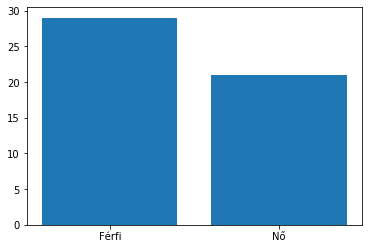

In [8]:
if the_country == 'Hungary':
    df = pd.read_html('https://koronavirus.gov.hu/elhunytak')
    df = pd.DataFrame(df[0])
    df.drop(['Sorszám', 'Alapbetegségek'], axis=1, inplace = True)
    gr = df.groupby(['Nem']).count()
    plt.bar(gr.index, gr['Kor'])
    print('Férfi átlag: ', round(df[df['Nem'] == 'Férfi'].Kor.mean(),2))
    print('Női átlag:   ', round(df[df['Nem'] == 'Nő'].Kor.mean(),2))

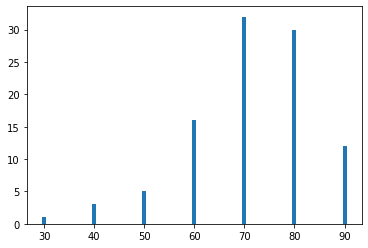

In [9]:
if the_country == 'Hungary':    
    hf.reset_index(inplace=True)
    plt.bar(hf['Kor'], hf['Eset/Korcsoport'], align='center')

Bács-Kiskun                22
Baranya                    29
Békés                      11
Borsod-Abaúj-Zemplén       44
Budapest                  669
Csongrád                   45
Fejér                      93
Győr-Moson-Sopron          60
Hajdú-Bihar                18
Heves                       9
Jász-Nagykun-Szolnok       14
Komárom-Esztergom          20
Nógrád                     18
Pest                      215
Somogy                     20
Szabolcs-Szatmár-Bereg     38
Tolna                      13
Vas                        14
Veszprém                   30
Zala                       28
Name: 2020.04.12, dtype: int64

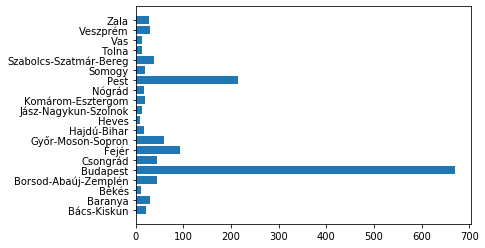

In [76]:
url = 'korona_megyei.csv'
df = pd.read_csv(url, sep=';')
df = df.set_index('Dátum', drop = True)   
df = df.T.iloc[:,-1]
df.columns = ['eset']
plt.barh(df.index, df)
df

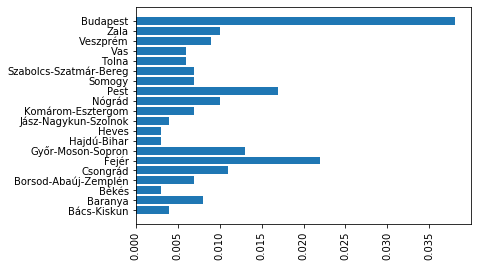

In [98]:
url = r'https://hu.wikipedia.org/wiki/Magyarorsz%C3%A1g_megy%C3%A9i'
dl = pd.read_html(url)
mf = pd.DataFrame(dl[0][['Megye','Népesség']])
mf.dropna(inplace = True)
mf.T.loc['Megye',20] = 'Budapest'
mf.columns = ['megye', 'lakos']
mf.set_index('megye', drop = True, inplace = True)
st = lambda x: int(x.replace('\xa0',''))
mf['lakos'] = mf['lakos'].apply(st)
mf['eset'] = df
mf['százalék'] = round(mf.eset / mf.lakos * 100,3)
plt.xticks(rotation='vertical')
plt.barh(mf.index, mf['százalék'])
plt.show()